<a href="https://colab.research.google.com/github/chminPark/ml-python/blob/master/%EC%8B%A4%EC%8A%B5_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Backpropagation의 순서
* 784개의 입력이 들어가고, 10개의 class를 분류하는 문제임
* Foreward path를 통해 10개 Class 각각에 대한 확률을 계산 (feat Softmax)
* Backward path를 통해 각 Layer의 인자들을 계산한다.

![](https://drive.google.com/uc?export=view&id=1cz59PIGod0O0M17cfzSRM6DmjE5CIyLh)





In [ ]:
# Pytorch로 개발하기 위한 Library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import os
import gzip
import numpy as np
from urllib import request
from tqdm import tqdm

torch.__version__

'2.1.0+cu118'

## MNIST 데이터셋
* MNIST는 사람 손으로 쓴 0~9까지의 숫자 이미지로 이루어진 컴퓨터 비젼 데이터셋
* 28 x 28 (784 pixels) 의 흑백 이미지로 구성되어 있음

<img src="https://mblogthumb-phinf.pstatic.net/MjAxODEwMjNfMjg1/MDAxNTQwMjg0ODM2OTQz.OUbvtSh54EYNfjBCpE13-jAOD2KrVQ6BEegpa6IokU4g.pFVcA3eevZE_Enm9g4awAQVPzROLzt6IGcvTRILTZw4g.PNG.ackbary/image.png?type=w800" height="100px" width="400px">



In [ ]:
#Download MNIST Dataset

mnist_url = "http://yann.lecun.com/exdb/mnist/"
files = ["train-images-idx3-ubyte.gz","t10k-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz","t10k-labels-idx1-ubyte.gz"]
if not os.path.exists('mnist'):
  os.mkdir('mnist')
for file in files:
  if not os.path.isfile('mnist/'+file):
    request.urlretrieve(mnist_url+file, 'mnist/'+file)


In [ ]:
# Bype 정보에서 MNIST 데이터 확보
with gzip.open('mnist/train-images-idx3-ubyte.gz', 'r') as f:
  magic_number = int.from_bytes(f.read(4), 'big')
  num_images_training = int.from_bytes(f.read(4), 'big')
  row_count = int.from_bytes(f.read(4), 'big')
  column_count = int.from_bytes(f.read(4), 'big')
  train_images_data = f.read()
  train_images = np.frombuffer(train_images_data, dtype=np.uint8).reshape(num_images_training, row_count, column_count)

with gzip.open('mnist/train-labels-idx1-ubyte.gz', 'r') as f:
  magic_number = int.from_bytes(f.read(4), 'big')
  label_count = int.from_bytes(f.read(4), 'big')
  train_labels_data = f.read()
  train_labels = np.frombuffer(train_labels_data, dtype=np.uint8)

with gzip.open('mnist/t10k-images-idx3-ubyte.gz', 'r') as f:
  magic_number = int.from_bytes(f.read(4), 'big')
  num_images_test = int.from_bytes(f.read(4), 'big')
  row_count = int.from_bytes(f.read(4), 'big')
  column_count = int.from_bytes(f.read(4), 'big')
  test_images_data = f.read()
  test_images = np.frombuffer(test_images_data, dtype=np.uint8).reshape(num_images_test, row_count, column_count)

with gzip.open('mnist/t10k-labels-idx1-ubyte.gz', 'r') as f:
  magic_number = int.from_bytes(f.read(4), 'big')
  label_count = int.from_bytes(f.read(4), 'big')
  test_labels_data = f.read()
  test_labels = np.frombuffer(test_labels_data, dtype=np.uint8)

print("Training Images Shape:" , train_images.shape)
print("Training Labels Shape:" ,train_labels.shape)
print("Test Images Shape:" ,test_images.shape)
print("Test Labels Shape:" ,test_labels.shape)



Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


In [ ]:
def display_dataset(images, labels):
  idxs = np.random.choice(len(labels), 5, replace=False)
  plt.figure(figsize=(10, 4))
  for i, idx in enumerate(idxs):

    ################### 실습 : row 1개 col 5개의 이미지를 출력. 이미지는 plt.imshow로 출력합니다
    plt.subplot(1, 5, i+1)
    plt.imshow(images[idx], cmap='gray_r')
    #####################################################################
    plt.title('Digit : {} '.format(labels[idx]), fontsize=14)
    plt.xticks([]); plt.yticks([])

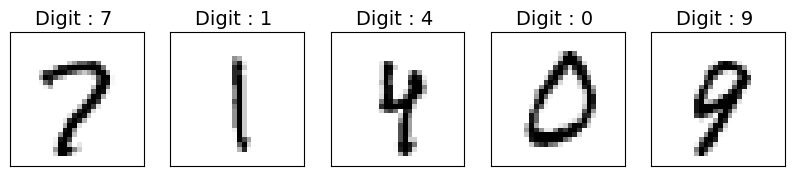

In [ ]:
# 학습 데이터의 이미지
display_dataset(train_images, train_labels)

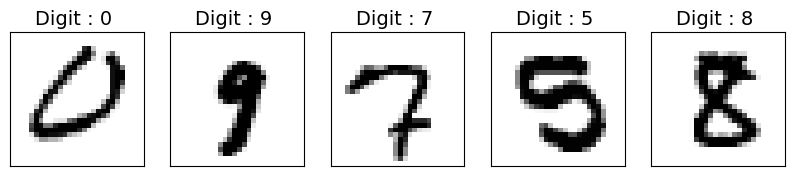

In [ ]:
# 평가 데이터의 이미지
display_dataset(test_images, test_labels)

In [ ]:
train_images[0].shape, 28*28

((28, 28), 784)

### MLP 구성 : Foreward Propagation (1)

* 금번 실습에서 non-linearity 를 추가하기 위해서 Activation Function으로 Sigmoid 활용.
  * Sigmoid 함수 : $g(z) = \frac{1}{1+ e^{-z}}$
  * Sigmoid 함수의 미분값 : $g'(z) = g(z)(1-g(z))$
  
* 2nd Layer의 출력은 Softmax를 통과하여 0~1 사이의 값을 가진다.
  * ${y}_{i}$ = $\frac{e^{x_i}}{\sum_{j=1}^{C}e^{x_j}}$
  * softmax 함수의 미분값:  $\frac{\partial {y}_i}{\partial x_j} = \begin{cases}
    y_i(1-y_i)& \quad \text{if  } i = j\\
    -y_iy_j &  \quad \text{if  } i \neq j
    \end{cases}$

In [ ]:
def softmax(x):
  exp = np.exp(x)
  return exp/np.sum(exp, axis=1, keepdims=True)

##########################################################
##################### 실습: sigmoid 함수를 선언해 보세요
def sigmoid(z):
  exp = np.exp(-z)
  return 1. / (1. + exp)
##########################################################

Text(0, 0.5, '$Softmax(x)$')

<Figure size 1500x1500 with 0 Axes>

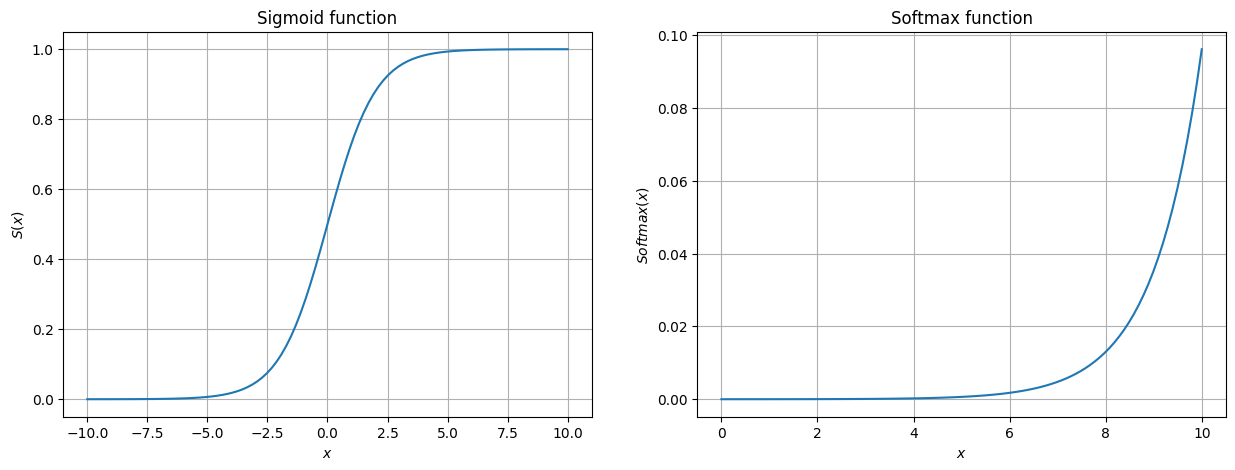

In [ ]:
inputs = np.linspace(-10, 10, 100)
figure = plt.figure(figsize=(15,15))

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(inputs, sigmoid(inputs))
ax[0].grid(True)
ax[0].set_title('Sigmoid function')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$S(x)$')

x = np.linspace(0, 10, 100).reshape(1,-1)
ax[1].plot(x[0], softmax(x)[0])
ax[1].grid(True)
ax[1].set_title('Softmax function')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$Softmax(x)$')


### MLP 구성 : Foreward Propagation (2)
* `__init__()` : MLP 구성요소 선언
* `foreward()` : foreward propagation

1) 1st Linear Layer는 입력 X를 받아 선형연산을 통해 z[1] 을 결과로 만들어 준다

2) 1st Linear의 결과 z[1] 은 Activation function g() 를 통과해 a[1] 의 결과를 만들어 낸다

3) 2nd Linear Layer는 Activation function g()의 결과인 a[1]을 받아 z[2]를 만들어 낸다

4) Classification 문제이므로 softmax 를 통과 시켜 예측값을 만들어 낸다


In [ ]:
input_size = 28*28
output_size = 10
hidden_size = 120

In [ ]:
# 1st Linear Layer의 인자
W1 = np.random.normal(size=(input_size, hidden_size))
b1 = np.random.normal(size=(1, hidden_size))

######################################################################
##################### 실습: 2nd Linear Layer 의 인자를 선언해 보세요
W2 = np.random.normal(size=(hidden_size, output_size))
b2 = np.random.normal(size=(1, output_size))
######################################################################

In [ ]:
class SingleHIddenMLP:
  def __init__(self, input_size, hidden_layer_size, output_size, activation):

    # 모델 구성에 필요한 인자
    self.input_size = input_size
    self.hidden_layer_size = hidden_layer_size
    self.output_size = output_size
    self.activation = activation

    ###################### 실습: 1st Linear Layer의 인자를 구성해 보세요
    self.W1 = np.random.normal(size=(self.input_size, self.hidden_layer_size))
    self.b1 = np.random.normal(size=(1, self.hidden_layer_size,))

    ###################### 실습: 2nd Linear Layer의 인자를 구성해 보세요
    self.W2 = np.random.normal(size=(self.hidden_layer_size, self.output_size))
    self.b2 = np.random.normal(size=(1, self.output_size))



  def forward(self,input):

    ##### 입력을 만들어 봅시다.
    batchsize = len(input)
    input = input.reshape(batchsize, -1)

    ############### 실습 : 1st Linear Layer의 연산인 xW + b를 구현해 보세요
    self.linear_l1 = np.matmul(input, self.W1) + self.b1
    ##############################

    self.activation_l1 = self.activation(self.linear_l1)

    ############### 실습 : 2nd Linear Layer의 연산인 self.activation_l1*W + b를 구현해 보세요
    self.linear_l2 = np.matmul(self.activation_l1, self.W2) + self.b2

    # Softmax activation for multi-class classification
    activation_l2 = softmax(self.linear_l2)
    return activation_l2


In [ ]:
# 사진 1장을 넣었을 때의 결과는?
model = SingleHIddenMLP(input_size=input_size, output_size=output_size, hidden_layer_size=hidden_size, activation=sigmoid)
output =  model.forward(train_images[0:1])
output, np.sum(output)

<ipython-input-8-b4a916cc13d6>:8: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-z)


(array([[2.62697360e-01, 6.51726454e-07, 4.72951384e-10, 1.34658534e-02,
         1.89232200e-04, 1.73544253e-02, 1.14439595e-09, 1.36081829e-03,
         2.35152634e-01, 4.69779023e-01]]),
 1.0)

### MLP 구성 : Backward Propagation (1)
* `__init__()` : MLP 구성요소 선언
* `foreward()` : foreward propagation
* `compute_loss()` : Compute Average Cross Entropy Loss
* `update()` : GD방식을 이용하여 NN의 Weight 업데이트

<ipython-input-14-ce358242a560>:7: RuntimeWarning: divide by zero encountered in log
  y = -np.log(x)


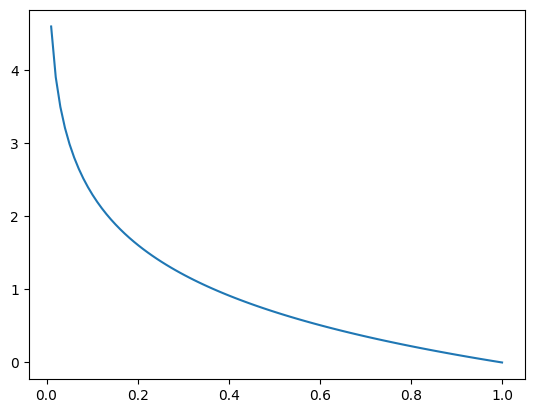

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

######### 실습 : 0~1 사이에 100개의 숫자를 만들어 보고, y=-log(x)를 계산하여 출력해 봅니다.

x = np.linspace(0,1,100)  # 0~1 사이의 값을 만들어 본다
y = -np.log(x)
plt.plot(x, y)

In [ ]:
class SingleHIddenMLP:
  def __init__(self, input_size, hidden_layer_size, output_size, activation, learning_rate):

    # 모델 구성에 필요한 인자
    self.input_size = input_size
    self.hidden_layer_size = hidden_layer_size
    self.output_size = output_size
    self.activation = activation

    # 학습에 필요한 인자
    self.learning_rate = learning_rate

    #1st Linear Layer의 인자를 구성해 보세요
    self.W1 = np.random.normal(size=(self.input_size, self.hidden_layer_size))
    self.b1 = np.random.normal(size=(1, self.hidden_layer_size,))

    #2nd Linear Layer의 인자를 구성해 보세요
    self.W2 = np.random.normal(size=(self.hidden_layer_size, self.output_size))
    self.b2 = np.random.normal(size=(1, self.output_size))

    # 1st Linear Layer의 Gradients
    self.W1_grad = np.zeros(shape=(self.input_size, self.hidden_layer_size))
    self.b1_grad = np.zeros(shape=(1, self.hidden_layer_size,))

    # 2nd Linear Layer의 Gradients
    self.W2_grad = np.zeros(shape=(self.hidden_layer_size, self.output_size))
    self.b2_grad = np.zeros(shape=(1, self.output_size))

  def forward(self,input):

    batchsize = len(input)
    input = input.reshape(batchsize, -1)

    #1st Linear Layer의 연산인 xW + b & activation fucntion
    self.linear_l1 = np.matmul(input, self.W1) + self.b1
    self.activation_l1 = self.activation(self.linear_l1)

    #2nd Linear Layer의 연산인 self.activation_l1*W + b
    self.linear_l2 = np.matmul(self.activation_l1, self.W2) + self.b2

    # Softmax activation for multi-class classification
    activation_l2 = softmax(self.linear_l2)
    return activation_l2

  def compute_loss(self,prediction, target):
    ############## 실습 Cross Entropy Loss : target * log(softmax의 결과)
    loss = target * np.log(prediction)
    ####################################################################
    loss = - np.sum(loss.flatten())/len(target)
    return loss

  def update(self):

    ####실습 : Gradient Descent에 기반하여 Weight update
    #### (ex. optimizer.step)
    self.W1 -= self.learning_rate * self.W1_grad
    self.b1 -= self.learning_rate * self.b1_grad
    self.W2 -= self.learning_rate * self.W2_grad
    self.b2 -= self.learning_rate * self.b2_grad
    ##################################################

    # Update 이후 초기화 (ex. Optimizer.zero_grad())
    self.W1_grad = np.zeros(shape=(self.input_size, self.hidden_layer_size))
    self.b1_grad = np.zeros(shape=(1, self.hidden_layer_size,))
    self.W2_grad = np.zeros(shape=(self.hidden_layer_size, self.output_size))
    self.b2_grad = np.zeros(shape=(1, self.output_size))


<ipython-input-8-b4a916cc13d6>:8: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-z)


예측값은 예측할 Class의 개수의 크기 : (1, 10)
Cross Entropy Loss is 0.18636698862764328
Predicted Label: 3
원하는 Loss는 : 9.00405243164155e-05


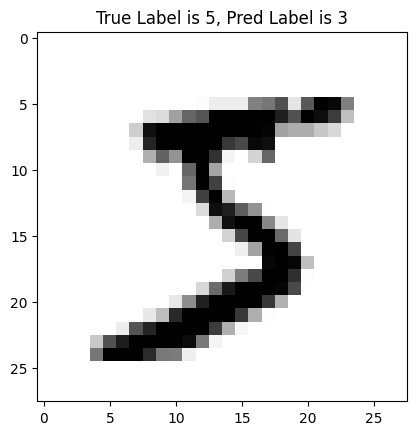

In [ ]:
# 사진 1장을 넣었을 때의 결과는?
############### 실습 : 모델을 선언하고 입력에 대한 예측을 수행해 본다.
model = SingleHIddenMLP(input_size=input_size, output_size=output_size, hidden_layer_size=hidden_size, activation=sigmoid, learning_rate=0.1 )
predictions =  model.forward(train_images[0:1])
###################################################################################

plt.imshow(train_images[0], cmap='gray_r')

print (f"예측값은 예측할 Class의 개수의 크기 : {predictions.shape}")

######## 실습 : 예측한 Class 를 확인한다
######## 길이 10 array 내 가장 큰 수를 가진 인자의 Index 값이 예측 Class
pred_label = np.argmax(predictions)
#################################################################

plt.title(f"True Label is {train_labels[0]}, Pred Label is {pred_label}")
target = np.eye(10)[train_labels[0]]
print(f"Cross Entropy Loss is {model.compute_loss(predictions, target)}")
print (f"Predicted Label: {pred_label}")

### Optimal Loss
print(f"원하는 Loss는 : {model.compute_loss(np.array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.9991, 0.0001, 0.0001,0.0001, 0.0001]), target)}")

### MLP 구성 : Backward Propagation (2)
* `__init__()` : MLP 구성요소 선언
* `foreward()` : foreward propagation
* `compute_loss()` : Compute Cross Entropy Loss
* `update()` : SGD방식을 이용하여 NN의 Weight 업데이트
* `backward()` : backward propagation

[수행방향]

1) W2와 b2 로 Cost를 미분한 값을 계산한다.
2) W1과 b1으로 Cost를 미분한 값을 계산한다.

Text(0, 0.5, '$S(x)$')

<Figure size 1500x1500 with 0 Axes>

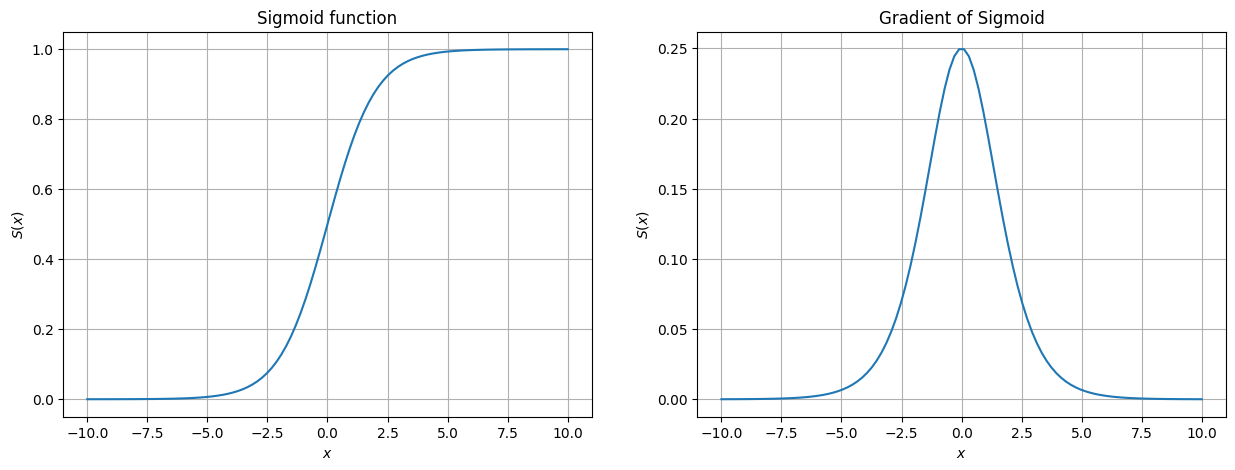

In [ ]:
def softmax_grad(softmax_output):
  return np.diag(softmax_output.squeeze()) - np.matmul(softmax_output.T, softmax_output)

##########################################################
##################### 실습: sigmoid 의 Gradient 를 선언해 보세요
def sigmoid_grad(sigmoid_output):
  return sigmoid_output  * (1.-sigmoid_output)
##########################################################

inputs = np.linspace(-10, 10, 100)
figure = plt.figure(figsize=(15,15))

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(inputs, sigmoid(inputs))
ax[0].grid(True)
ax[0].set_title('Sigmoid function')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$S(x)$')

ax[1].plot(inputs, sigmoid_grad(sigmoid(inputs)))
ax[1].grid(True)
ax[1].set_title('Gradient of Sigmoid')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$S(x)$')



In [ ]:
class SingleHIddenMLP:
  def __init__(self, input_size, hidden_layer_size, output_size, activation, activation_grad, learning_rate):

    # 모델 구성에 필요한 인자
    self.input_size = input_size
    self.hidden_layer_size = hidden_layer_size
    self.output_size = output_size
    self.activation = activation

    # 학습에 필요한 인자
    self.activation_grad = activation_grad
    self.learning_rate = learning_rate

    #1st Linear Layer의 인자를 구성해 보세요
    self.W1 = np.random.normal(size=(self.input_size, self.hidden_layer_size))
    self.b1 = np.random.normal(size=(1, self.hidden_layer_size,))

    #2nd Linear Layer의 인자를 구성해 보세요
    self.W2 = np.random.normal(size=(self.hidden_layer_size, self.output_size))
    self.b2 = np.random.normal(size=(1, self.output_size))

    # 1st Linear Layer의 Gradients
    self.W1_grad = np.zeros(shape=(self.input_size, self.hidden_layer_size))
    self.b1_grad = np.zeros(shape=(1, self.hidden_layer_size,))

    # 2nd Linear Layer의 Gradients
    self.W2_grad = np.zeros(shape=(self.hidden_layer_size, self.output_size))
    self.b2_grad = np.zeros(shape=(1, self.output_size))

  def forward(self,input):

    batchsize = len(input)
    input = input.reshape(batchsize, -1)

    #1st Linear Layer의 연산인 xW + b & activation fucntion
    self.linear_l1 = np.matmul(input, self.W1) + self.b1
    self.activation_l1 = self.activation(self.linear_l1)

    #2nd Linear Layer의 연산인 self.activation_l1*W + b
    self.linear_l2 = np.matmul(self.activation_l1, self.W2) + self.b2

    # Softmax activation for multi-class classification
    activation_l2 = softmax(self.linear_l2)
    return activation_l2

  def compute_loss(self,prediction, target):
    loss = target * np.log(prediction)
    loss = - np.sum(loss.flatten())/len(target)
    return loss

  def update(self):
    self.W1 -= self.learning_rate * self.W1_grad
    self.b1 -= self.learning_rate * self.b1_grad
    self.W2 -= self.learning_rate * self.W2_grad
    self.b2 -= self.learning_rate * self.b2_grad


    # Update 이후 초기화
    self.W1_grad = np.zeros(shape=(self.input_size, self.hidden_layer_size))
    self.b1_grad = np.zeros(shape=(1, self.hidden_layer_size,))
    self.W2_grad = np.zeros(shape=(self.hidden_layer_size, self.output_size))
    self.b2_grad = np.zeros(shape=(1, self.output_size))

  def backward(self,prediction, target, input):

    batchsize = len(input)  # 계산하는 Image의 갯수
    input = input.reshape(batchsize, -1)

    # 역전파 Step 1: dCost/dy
    gradient_activation_l2 = -(target)/(prediction + 1e-9)

    # 역전파 Step 2: dCost/dz[2]
    gradient_linear_l2 = np.matmul(gradient_activation_l2, softmax_grad(prediction))

    # 역전파 Step 3: dCost/dW[2], dCost/db[2], dCost/da[1]
    self.W2_grad = np.matmul(self.activation_l1.T,gradient_linear_l2 )/batchsize
    self.b2_grad = np.sum(gradient_linear_l2, axis=0)/batchsize
    gradient_activation_l1 = np.matmul(gradient_linear_l2, self.W2.T)

    # 역전파 Step 4: dCost/dz[1], dCost/dW[1]. dCost/db[1]
    gradient_linear_l1 = gradient_activation_l1 * self.activation_grad(self.activation_l1)
    self.W1_grad = np.matmul(input.T, gradient_linear_l1)/batchsize
    self.b1_grad = np.sum(gradient_linear_l1, axis=0)/batchsize

    return


### 학습 및 평가
* 입력 크기 : 28x28=784
* hidden layer 크기 = 120
* output 크기 : 10 (0~9 까지의 숫자를 맞추는 문제)
* 이미지 별로 학습을 수행하며, Epoch = 3

In [ ]:
np.random.seed(0)

### 모델 선언 시 Weight들의 초기화는 이루어져 있음
model = SingleHIddenMLP(input_size=784, hidden_layer_size=120,
                        output_size=10, activation=sigmoid, activation_grad=sigmoid_grad,
                        learning_rate=0.1)
max_epoches = 3
for epoch in tqdm(range(max_epoches)):
  indices = np.arange(len(train_images))

  ##### 섞어줌
  np.random.shuffle(indices)
  train_images_shuffle = train_images[indices]
  train_labels_shuffle = train_labels[indices]

  running_loss = 0.0
  for i in range(len(train_images)):

    ################## 실습 : 입력 이미지는 Normalization
    input = train_images_shuffle[i:i+1]/255.0
    ##################################################
    label = train_labels_shuffle[i:i+1]

    ############### 실습 : Cross Entropy계산을 위한 one-hot Vector생성
    label_onehot = np.eye(10)[label]
    ##################################################

    # 예측값 생성
    prediction = model.forward(input)
    running_loss += model.compute_loss(prediction, label_onehot)

    ########## 실습:  Backpropagation을 통해 모델 학습
    model.backward(prediction, label_onehot, input)
    model.update()
    ##################################################
  print('Loss = {}'.format(running_loss/len(train_images)))
print('Training Finished')

 33%|███▎      | 1/3 [01:47<03:35, 107.72s/it]

Loss = 0.5012609259579799


 67%|██████▋   | 2/3 [03:18<01:37, 97.61s/it] 

Loss = 0.23153933129122573


100%|██████████| 3/3 [04:48<00:00, 96.15s/it]

Loss = 0.166858308157154
Training Finished


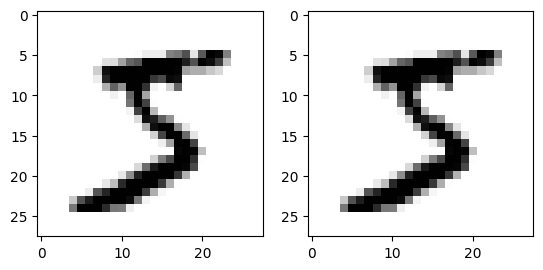

In [ ]:
######### 정규화를 해도 문제가 없습니다.
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_images[0], cmap='gray_r')
ax[1].imshow(train_images[0]/255.0, cmap='gray_r') # 흑백이미지에서 0:Black, 255: White

<ipython-input-8-b4a916cc13d6>:8: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-z)


Test Accuracy = 94.42


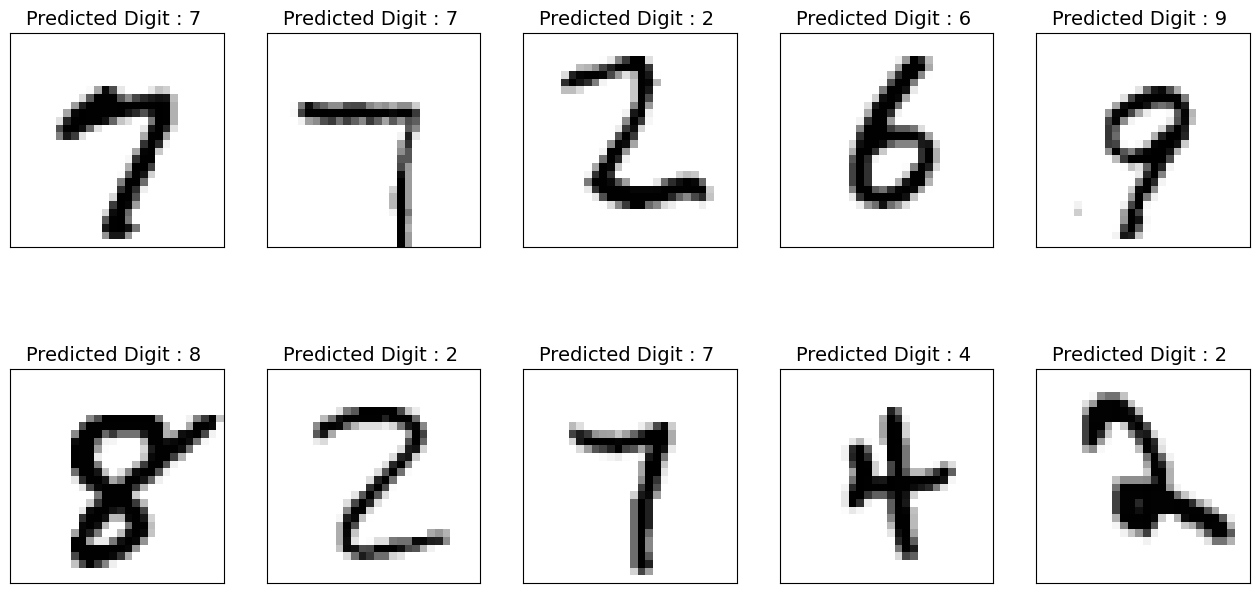

In [ ]:
# 학습된 모델에 대한 성능 평가
prediction = model.forward(test_images)
prediction_label = np.argmax(prediction, axis=1)

# Accuracy : 예측값과 정답값이 같은 비중
test_acc = np.sum((prediction_label == test_labels))/len(test_labels)
print('Test Accuracy = {:.2f}'.format(100*test_acc))

# Plotting results
idxs = np.random.choice(len(test_labels), 10, replace=False)
plt.figure(figsize=(16, 8))
predict = model.forward(test_images[idxs])
pred_label = np.argmax(predict, axis=1)
for i, idx in enumerate(idxs):
  plt.subplot(2, 5, i + 1)
  plt.imshow(test_images[idx], cmap='gray_r')
  plt.title('Predicted Digit : {} '.format(pred_label[i]), fontsize=14)
  plt.xticks([]); plt.yticks([])

## nn.Linear 로 구현해 봅시다

* Pytorch 의 CrossEntropyLoss는 내부적으로 입력을 Softmax 처리하므로 모델의 마지막에 softmax가 없어도 됩니다

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class LinearRegressionModel(nn.Module):

  def __init__(self, input_size, hidden_layer_size, output_size):
    super().__init__()

    ############ 실습 : 위에 구현한 모델을 Pytorch로 구현해 봅니다.
    #### Pytorch의  Cross Entropy Loss는 내부적으로 입력을 Softmax처리
    #### 하므로 모델의 마지막에 Softmax가 없어도 됩니다.
    self.linear = nn.Sequential(nn.Linear(in_features=input_size, out_features=hidden_layer_size, bias=True),
                                nn.Sigmoid(),
                                nn.Linear(in_features=hidden_layer_size, out_features=output_size, bias=True),
                                # nn.Softmax()
                            )
    ###################################

  def forward(self, x):
      return self.linear(x)

<ipython-input-23-e946887f91d8>:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  x_train = torch.from_numpy(train_images.reshape(len(train_images), -1)).float()


학습 전 예측결과
Initial Cost: 2.383118152618408


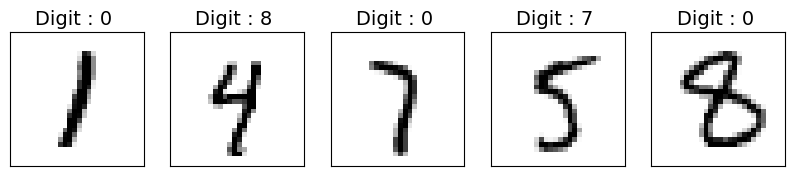

In [ ]:
####### 실습 : Numpy 이미지는 Tensor로 선언
x_train = torch.from_numpy(train_images.reshape(len(train_images), -1)).float()
x_test = torch.from_numpy(test_images.reshape(len(test_images), -1)).float()
y_train = torch.from_numpy(train_labels)
y_test = torch.from_numpy(test_labels)
################

model = LinearRegressionModel(input_size=784, hidden_layer_size=120, output_size=10)
preds = model(x_train)

print("학습 전 예측결과")
display_dataset(train_images, np.argmax(preds.detach().numpy(), axis=1))

loss =  nn.CrossEntropyLoss() # 내부적으로 소프트맥스 함수를 포함하고 있음.
print(f"Initial Cost: {loss(preds, y_train)}")


Epoch    1/15, Cost_train: 2.087355
Epoch    4/15, Cost_train: 1.631766
Epoch    7/15, Cost_train: 1.367664
Epoch   10/15, Cost_train: 1.205482
Epoch   13/15, Cost_train: 1.082580
학습 후 예측결과
Train accuracy :  0.8175
Test accuracy :  0.8273


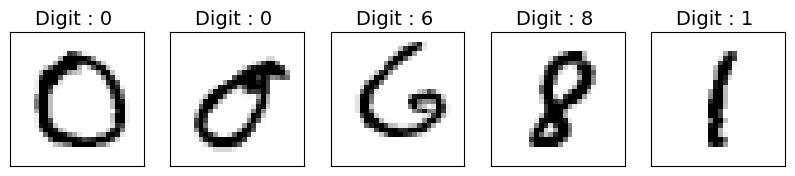

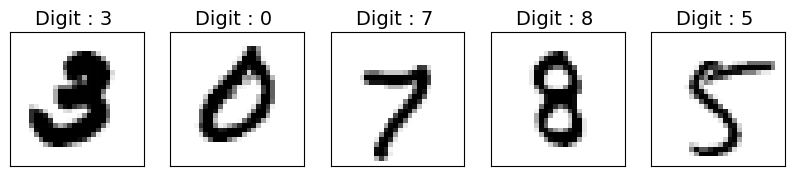

In [ ]:
########## 실습 : SGD 최적화 모델 활용
optimizer = torch.optim.SGD( model.parameters(), lr=0.1)
#########################################################

nb_epochs = 15 # 원하는만큼 경사 하강법을 반복
for epoch in range(nb_epochs + 1):

    preds = model(x_train)

    cost = loss(preds, y_train)

    ######## 실습 : SGD를 이용하여 학습을 수행합니다.
    optimizer.zero_grad() # 초기화
    cost.backward() # gradient계산
    optimizer.step() # 계산된 gradient 값을 이용하여 W,b 업데이트
    #####################################################

    if epoch % (nb_epochs/10) == 1:
      print(f'Epoch {epoch:4d}/{nb_epochs}, Cost_train: {cost.item():.6f}')

preds = model(x_train)
print("학습 후 예측결과")
prediction_label = np.argmax(preds.detach().numpy(), axis=1)
display_dataset(train_images,prediction_label)
print(f"Train accuracy :  {np.sum((prediction_label == train_labels))/len(train_labels)}")

preds_test = model(x_test)
prediction_label = np.argmax(preds_test.detach().numpy(), axis=1)
display_dataset(test_images, prediction_label)
print(f"Test accuracy :  {np.sum((prediction_label == test_labels))/len(test_labels)}")


Test accuracy :  0.8273


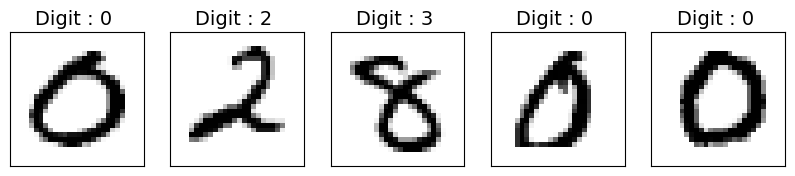

In [ ]:
preds_test = model(x_test)
prediction_label = np.argmax(preds_test.detach().numpy(), axis=1)
display_dataset(test_images, prediction_label)
print(f"Test accuracy :  {np.sum((prediction_label == test_labels))/len(test_labels)}")

In [ ]:
test_labels.shape, prediction_label.shape

((10000,), (10000,))

In [ ]:
########### 실습 : 분류 성능을 평가해 봅니다.
from sklearn.metrics import classification_report
print(classification_report(test_labels, prediction_label))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       980
           1       0.88      0.97      0.92      1135
           2       0.87      0.78      0.83      1032
           3       0.75      0.85      0.80      1010
           4       0.86      0.84      0.85       982
           5       0.81      0.61      0.70       892
           6       0.89      0.90      0.89       958
           7       0.78      0.91      0.84      1028
           8       0.89      0.62      0.73       974
           9       0.79      0.75      0.77      1009

    accuracy                           0.83     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.83      0.82     10000



In [ ]:
########### 실습 : 분류 성능을 평가해 봅니다.
# Accuracy : # 전체 샘플중 맞게 예측한 샘플수 (TP + TN) / Total
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, prediction_label)

0.8273

In [ ]:
########### 실습 : 분류 성능을 평가해 봅니다.
# Precision 정밀도 : 예측값 값의 정확도
from sklearn.metrics import precision_score
# 각 label의 prediction을 계산 후 평균을 취함
precision_score(test_labels, prediction_label, average = 'macro')

0.8308048919849138

In [ ]:
########### 실습 : 분류 성능을 평가해 봅니다.
# recall : 실제 Positive중 Positive라고 예측된 비중
from sklearn.metrics import recall_score
recall_score(test_labels, prediction_label, average = 'macro')

0.8230608439460833

In [ ]:
########### 실습 : 분류 성능을 평가해 봅니다.
# f1 score : 정밀도와 재현율의 가중 조화평균
from sklearn.metrics import f1_score
print(f1_score(test_labels, prediction_label, average = 'macro'))

0.8207910697717583
